In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 


In [2]:
spx_path = "data/SPX_database_2010.xlsx"
df_tri = pd.read_excel(spx_path, sheet_name="total_ret").set_index("Dates")
df_sofr = pd.read_excel("data/SOFR.xlsx")
df_sofr.rename(columns={"Data": "Dates"}, inplace=True)
df_sofr["Dates"] = pd.to_datetime(df_sofr["Dates"]) 
df_sofr = df_sofr.set_index("Dates").sort_index()
df_sofr["Taxa_diaria"] = ((1 + df_sofr["Price"]) ** (1/252)) -1
df_sofr

,Price,Taxa_diaria
Dates,,
2014-01-02,0.0005,0.000002
2014-01-03,0.0005,0.000002
2014-01-06,0.0005,0.000002
2014-01-07,0.0004,0.000002
2014-01-08,0.0004,0.000002
...,...,...
2025-07-28,0.0436,0.000169
2025-07-29,0.0436,0.000169
2025-07-30,0.0432,0.000168


In [3]:
def clean_column_names(df):
    new_columns = []
    for col in df.columns:
        if ' UN Equity' in str(col):
            new_columns.append(col.split(' UN Equity')[0])
        elif ' UW Equity' in str(col):
            new_columns.append(col.split(' UW Equity')[0])
        else:
            new_columns.append(col)
    return new_columns


/var/folders/pm/ps47mfm943x_nqjshcjsk5ch0000gn/T/ipykernel_19425/3249490106.py:38: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  prices = prices.groupby(prices.columns, axis=1).mean()


Sample: 2010-01-01 00:00:00 -> 2025-08-01 00:00:00 (4066 trading days)


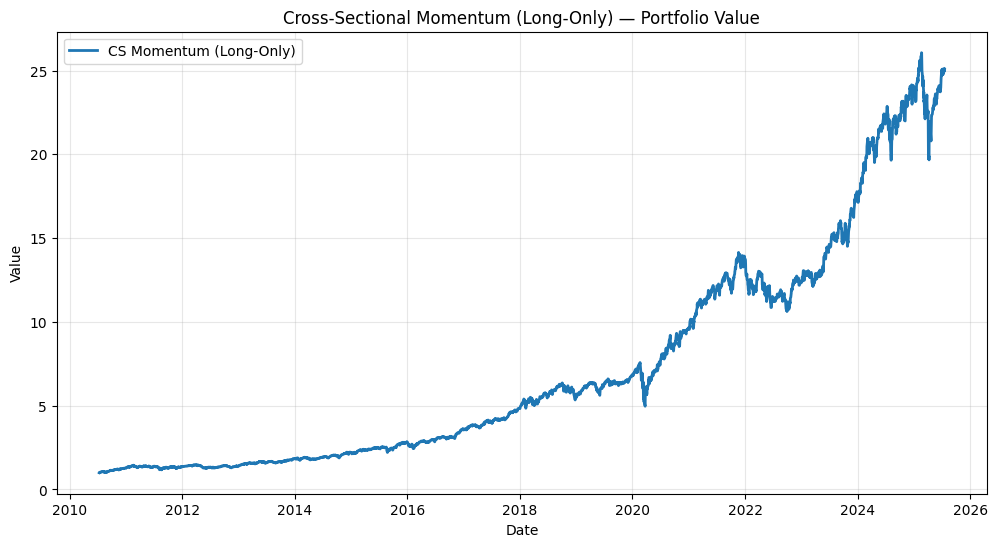

CROSS-SECTIONAL MOMENTUM (LONG-ONLY) METRICS
Days: 2909, Years ≈ 11.54
Annualized Return: 24.90%
Annualized Volatility: 21.52%
Sharpe vs SOFR: 1.078


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

periods_per_year = 252
lookback = 125
skip = 10
holding = 20
top_k = 10
initial_value = 1.0
per_asset_cap = 0.25   # optional cap to mirror Markowitz (<= 25% per name)

df_tri = df_tri.copy()
df_tri.index = pd.to_datetime(df_tri.index)


df_tri.columns = clean_column_names(df_tri)

tickers_30 = [
    "MSFT","AAPL","NVDA","GOOGL","IBM","AVGO","ADBE","CRM","INTC","INTU",
    "UNH","PFE","LLY","ABT","MRK","MCD","AMZN","COST","SBUX","PG",
    "JPM","GS","MS","BLK","CAT","DE","GE","XOM","NEE","ETN"
]
available = [t for t in tickers_30 if t in df_tri.columns]
if len(available) < len(tickers_30):
    print("Warning: not all requested tickers exist; using subset:", available)

prices = df_tri[available].copy()
prices = prices.select_dtypes(include=[np.number]).sort_index()

if prices.columns.duplicated().any():
    prices = prices.groupby(prices.columns, axis=1).mean()
assert not prices.columns.duplicated().any(), "Still have duplicated columns."

prices = prices.loc[prices.index >= "2010-01-01"]
prices = prices.dropna(axis=0, how="any")
print("Sample:", prices.index.min(), "->", prices.index.max(), f"({len(prices)} trading days)")

def cross_sectional_momentum_long_only(prices, lookback=252, skip=21, holding=60, top_k=10, per_asset_cap=None):
    """
    Long-only cross-sectional momentum:
      - Score = total return over [t-skip-lookback, t-skip]
      - Go long top_k winners only (equal-weighted by default)
      - Hold for 'holding' days, then form a new cohort
      - No shorts; losers have zero weight
      - Optional per-asset cap; weights re-normalized to sum to 1
    """
    returns = prices.pct_change()
    portfolio = []

    n = len(prices)
    start = lookback + skip
    stop = n - holding
    if stop <= start:
        raise ValueError("Insufficient length for lookback + skip + holding.")

    for t in range(start, stop + 1, holding):
        p_end = prices.iloc[t - skip]
        p_start = prices.iloc[t - skip - lookback]
        score = (p_end / p_start - 1).dropna()
        if score.empty:
            continue

        k = min(top_k, len(score))
        if k <= 0:
            continue

        winners = score.nlargest(k).index

        # long-only weights on winners
        w = pd.Series(0.0, index=prices.columns, dtype=float)
        w.loc[winners] = 1.0 / k

        if per_asset_cap is not None:
            w = w.clip(upper=per_asset_cap)
            s = w.sum()
            if s <= 0:
                continue
            w = w / s  # fully invested after capping

        # realized returns over the holding window
        window = returns.iloc[t+1 : t+1+holding][list(winners)]
        if window.shape[1] == 0:
            continue

        # align weights to window columns
        w_for_window = w.reindex(window.columns).fillna(0.0)
        port_rets_series = window.dot(w_for_window)
        portfolio.append(port_rets_series)

    if not portfolio:
        return pd.Series(dtype=float)

    cs_rets = pd.concat(portfolio).sort_index()
    # if overlapping timestamps, compound within-day
    if cs_rets.index.has_duplicates:
        cs_rets = (1 + cs_rets).groupby(cs_rets.index).prod() - 1
    cs_rets.name = "CS_LongOnly"
    return cs_rets

# run long-only CS momentum
cs_rets = cross_sectional_momentum_long_only(
    prices,
    lookback=lookback,
    skip=skip,
    holding=holding,
    top_k=top_k,
    per_asset_cap=per_asset_cap
)

# portfolio value
portfolio_value = (1 + cs_rets).cumprod() * initial_value

plt.figure(figsize=(12,6))
plt.plot(portfolio_value.index, portfolio_value.values, label='CS Momentum (Long-Only)', linewidth=2)
plt.title('Cross-Sectional Momentum (Long-Only) — Portfolio Value')
plt.xlabel('Date'); plt.ylabel('Value'); plt.grid(alpha=0.3); plt.legend(); plt.show()

# --- metrics vs SOFR (excess) ---
daily_rets = cs_rets.astype(float).dropna()

# align SOFR (use your df_sofr prepared earlier with column 'Taxa_diaria')
df_sofr = df_sofr.copy()
df_sofr.index = pd.to_datetime(df_sofr.index)
common_idx = daily_rets.index.intersection(df_sofr.index)
daily_rets = daily_rets.reindex(common_idx)
sofr_daily = df_sofr['Taxa_diaria'].reindex(common_idx)

n_days = len(daily_rets)
years = n_days / periods_per_year

mean_daily = daily_rets.mean()
annualized_return = mean_daily * periods_per_year
ann_vol = daily_rets.std(ddof=1) * np.sqrt(periods_per_year)
mean_rf_daily = sofr_daily.mean()
sharpe = ((mean_daily - mean_rf_daily) * periods_per_year) / (ann_vol if ann_vol != 0 else np.nan)

print("=" * 60)
print("CROSS-SECTIONAL MOMENTUM (LONG-ONLY) METRICS")
print("=" * 60)
print(f"Days: {n_days}, Years ≈ {years:.2f}")
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Annualized Volatility: {ann_vol:.2%}")
print(f"Sharpe vs SOFR: {sharpe:.3f}")
print("=" * 60)

In [5]:
# Save cumulative returns to CSV
cs_cumulative_returns = pd.DataFrame({
    'Date': portfolio_value.index,
    'Cumulative Return': (portfolio_value / initial_value) - 1
})
cs_cumulative_returns.to_csv('results/cross_sectional_cumulative_returns.csv', index=False)
print("Cross-Sectional Momentum cumulative returns saved to results/cross_sectional_cumulative_returns.csv")

OSError: Cannot save file into a non-existent directory: 'results'